# `litebird_sim` example notebook 

**Attention! This notebook can work only after having downloaded the Litebird IMO information.**

You will have to ask the permission to access the private repository https://github.com/litebird/litebird_imo and then install it following [the documentation](https://litebird-sim.readthedocs.io/en/master/tutorial.html#interacting-with-the-imo).

To run this notebook, you should have already installed `litebird_sim` using the command

```
pip install .
```

## Set up the environment

We start by importing a few libraries that will be useful in this notebook.

In [1]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import astropy
from astropy.time import Time
import os
import h5py

%matplotlib inline

--------------------------------------------------------------------------
The library attempted to open the following supporting CUDA libraries,
but each of them failed.  CUDA-aware support is disabled.
libcuda.so.1: cannot open shared object file: No such file or directory
libcuda.dylib: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.so.1: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.dylib: cannot open shared object file: No such file or directory
If you are not interested in CUDA-aware support, then run with
--mca opal_warn_on_missing_libcuda 0 to suppress this message.  If you are interested
in CUDA-aware support, then try setting LD_LIBRARY_PATH to the location
of libcuda.so.1 to get passed this issue.
--------------------------------------------------------------------------


# Parameters of the simulation

We will simulate a pair of 140 GHz MFT detectors. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version 1.0.

In [2]:
telescope = "MFT"
channel = "M1-140"
detlist = ["M03_030_QA_140T", "M03_030_QA_140B"]

start_time = astropy.time.Time("2025-01-01T00:00:00")
mission_time_days = 365

imo_version = "v1.0"

# Resolution of the output maps
nside = 64

In [3]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
)

# Load the definition of the instrument (MFT)
inst_info = lbs.InstrumentInfo.from_imo(imo, f"/releases/{imo_version}/satellite/{telescope}/instrument_info")

In [4]:
# filling dets with info and detquats with quaternions of the detectors in detlist
dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )
    
    # we overwrite the nominal sampling rate read from IMO with a smaller one, so that
    # we produce 1 yr tod without taking too much memory
    det.sampling_rate_hz = 1
    
    dets.append(det)

The following command will take some time: it needs to compute the ephemerides of the Earth with respect to the Ecliptic reference frame and derive the orientation of the MFT instrument as a function of time for the whole duration of the simulation. This step will be needed later, when we will obtain the pointings for the detectors involved in the simulation.

In [5]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.generate_spin2ecl_quaternions(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

#### Making TOD and maps of CMB+foreground

Let's now create a set of «observations». This concept was mutuated by [TOAST](https://github.com/hpc4cmb/toast), and it represents a chunk of data acquired while the instrument was in almost stable conditions (i.e., stationary noise, no thermal drifts…). For the sake of simplicity, we create just *one* observation, but of course in realistic simulations you will have several observations spread among the available MPI processes.

In [6]:
# creating one observation
sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,      # blocks different from one if parallelizing
)

[<litebird_sim.observations.Observation object at 0x7f2203b4d790>]

The call above allocated the memory necessary to hold the TOD samples. However, to produce a map, we need pointing information, i.e., the information about the direction and orientation of each receiver as a function of time.

So, here comes the part where we need to simulate the pointings. Much of the work has already been done, as the ephemerides were already computed in the call to `sim.generate_spin2ecl_quaternions` (see above), but this step is going to take its time too, because we are now deriving the pointings for **each** detector and store them in the list `pointings`.

In [7]:
pointings = []
for obs in sim.observations:
    pointings.append(
        lbs.get_pointings(
            obs,
            spin2ecliptic_quats=sim.spin2ecliptic_quats,
            detector_quats=None,  # Just use the detector quaternions defined above
            bore2spin_quat=inst_info.bore2spin_quat,
            hwp=lbs.IdealHWP(
                inst_info.hwp_rpm * 2 * np.pi / 60,
            ),  # applies hwp rotation angle to the polarization angle
            store_pointings_in_obs=True,  # if True, stores colatitude and longitude in
            # sim.observations[:].pointings, and the polarization angle in
            # sim.observations[:].psi
        )
    )

`pointings` is a 3-rank matrix with a $N_{\rm{det}} \times N_{\rm{sample}} \times 3$ array, with the last rank containing the colatitude, longitude, and polarization angles (in radians). There are as many `pointings` arrays as the number of observations in `sim.observations`.

In [8]:
pointings[0].shape

(2, 31536000, 3)

Now we know where the detectors are looking at. Let's produce a synthetic image of the sky at the frequencies sampled by the two detectors we're simulating; for this, we need the information about the frequency channel we are simulating (140 GHz), so we retrieve them from the IMO again:

In [9]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

The LiteBIRD Simulation Framework provides MBS, which is a wrapper to PySM; we use it to produce a map of the sky including synchrotron, free-free, and dust, and we smooth the map according to the FWHM specified in the IMO. (Note that we do not need to pass this information explicitly, as MBS is able to extract it from `ch_info`.)

In [10]:
# let's make an input CMB+foreground map

# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    seed_cmb=1,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    gaussian_smooth=True,  # if True, smooths the input map by the beam of the channel
    bandpass_int=False,  # if True, integrates over the top-hat bandpass of the channel
    nside=nside,
    units="K_CMB",
    maps_in_ecliptic=False,
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=ch_info
    # detector_list = dets      #use detector_list instead of channel_list if your sim has detectors
    # from different channels. It would produce a map for each detector in dets
)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2022-06-20 22:30:20,211 INFO MPI#0000] generating and saving cmb simulations
[2022-06-20 22:30:20,236 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-06-20 22:30:20,238 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-06-20 22:30:20,355 INFO MPI#0000] Access data from /home/tomasi/Documents/work/LiteBIRD/simulations/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_220620.fits
[2022-06-20 22:30:20,367 INFO MPI#0000] NSIDE = 64
[2022-06-20 22:30:20,369 INFO MPI#0000] ORDERING = RING in fits file
[2022-06-20 22:30:20,371 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2022-06-20 22:30:20,665 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2022-06-20 22:30:20,666 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2022-06-20 22:30:20,669 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-06-20 22:30:20,670 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-06-20 22:30:20,732 INFO MPI#0000] generating and saving fg simulations
[2022-06-20 22:30:20,741 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2022-06-20 22:30:20,816 INFO MPI#0000] NSIDE = 512
[2022-06-20 22:30:20,818 INFO MPI#0000] ORDERING = RING in fits file
[2022-06-20 22:30:20,819 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-06-20 22:30:21,018 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2022-06-20 22:30:21,022 INFO MPI#0000] NSIDE = 512
[2022-06-20 22:30:21,023 INFO MPI#0000] ORDERING = RING in fits file
[2022-06-20 22:30:21,024 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-06-20 22:30:21,222 INFO MPI#0000] Retrieve da

It's time to simulate the observation of the map by the two receivers. This is done by the function `scan_map_in_observations`:

In [11]:
for i_obs, obs in enumerate(sim.observations):
    lbs.scan_map_in_observations(
        obs=obs,
        maps=maps,
        #   pointings = pointings[i_obs], #not needed if pointing already stored in the obs
        input_map_in_galactic=True,
    )

be careful, `lbs.scan_map_in_observations` adds signal to the observation.tod

The TOD has shape $N_{\rm{det}}$ x $N_{\rm{sample}}$

In [12]:
sim.observations[0].tod.shape

(2, 31536000)

# Map-making

Now that we have a TOD, let's bin it into a map! The LiteBIRD Simulation Framework provides two map-makers:

1. A simple binner, which is the first we'll use;

2. A wrapper to the Madam map-maker, provided through a binding to the TOAST2 library.

Let's start from the binner.

In [13]:
# This "for" cycle iterates over just one observation!
for i_obs, obs in enumerate(sim.observations):
    m_cmb_fg, m_cmb_fg_cov = lbs.make_bin_map(
        obs=obs,
        nside=nside,                     # one can set also a different resolution than the input map
        # pointings = pointings[i_obs],  # not needed if pointing already stored in the obs
        do_covariance=True,  # this generates the covariance maps
        output_map_in_galactic=True,
    )

The noise covariance matrix for each pixel is $\sigma^2 \left(A^T A\right)^{-1}$, where $A$ is the pointing matrix, with dimensions $N_{\rm{samples}} × \left(3 × N_{\rm{pixels}} \right)$ and $\sigma$ is in $\mu$K

$\left(A^T A\right)$ represents how many times the pixel has been visited, so $\sigma^2 \left(A^T A\right)^{-1}$ represents the noise of the pixel weighted by the times it has been observed

In [14]:
# the cov map has shape npix×3×3
m_cmb_fg_cov.shape

(49152, 3, 3)

<Figure size 612x388.8 with 2 Axes>

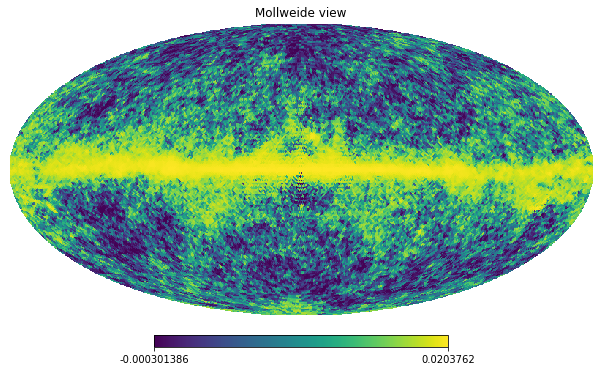

In [15]:
hp.mollview(m_cmb_fg[0], norm="hist")

<Figure size 1080x576 with 12 Axes>

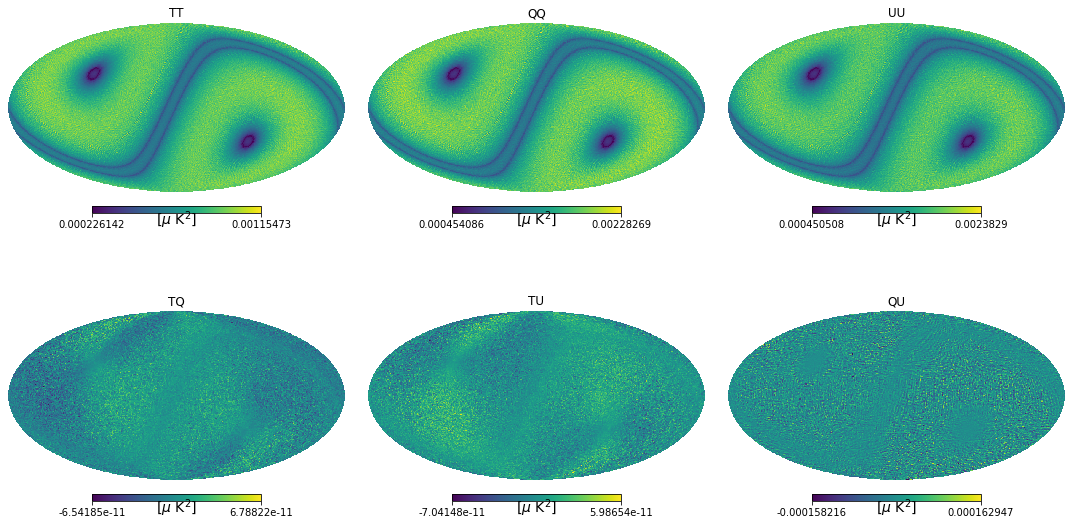

In [16]:
plt.figure(figsize=(15, 8))
hp.mollview(m_cmb_fg_cov[:, 0, 0], sub=231, title="TT", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 1, 1], sub=232, title="QQ", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 2, 2], sub=233, title="UU", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 0, 1], sub=234, title="TQ", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 0, 2], sub=235, title="TU", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 1, 2], sub=236, title="QU", unit=r"[$\mu$ K$^2$]")

The following map shows the difference between the input map and the output map:

<Figure size 612x388.8 with 2 Axes>

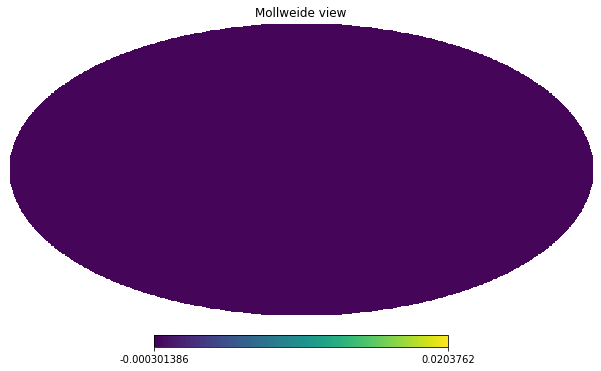

In [17]:
hp.mollview(maps["M1-140"][0] - m_cmb_fg[0], min=np.min(m_cmb_fg[0]), max=np.max(m_cmb_fg[0]))

## Making TOD and maps of white+1/f noise

Let's add white + 1/f noise to the CMB+FG TOD

In [18]:
for obs in sim.observations:
    lbs.add_noise_to_observations(
        obs=obs,
        noise_type="one_over_f",
        scale=1,  # it can be used to introduce measurement unit conversions when
        # appropriate. Default units: [K].
        # random=random      #The parameter `random`, if specified,
        # must be a random number generator that
        # implements the ``normal`` method
    )

Let's compare a noise map done with the `litebird_sim` binning mapmaker and with MADAM (binning and destriper). First the destriper:

In [19]:
param_noise_madam = lbs.DestriperParameters(
    nside=nside,
    return_hit_map=True,
    return_binned_map=True,
    return_destriped_map=True,
    coordinate_system=lbs.coordinates.CoordinateSystem.Galactic,
    iter_max=10,
)

In [20]:
result = lbs.destripe(sim=sim, params=param_noise_madam, pointings=pointings)

[2022-06-20 22:31:34,203 WARNING MPI#0000] converting pointings for M03_030_QA_140T from float32 to float64
[2022-06-20 22:31:34,384 WARNING MPI#0000] converting TODs for M03_030_QA_140T from float32 to float64
[2022-06-20 22:31:54,215 WARNING MPI#0000] converting pointings for M03_030_QA_140B from float32 to float64
[2022-06-20 22:31:54,881 WARNING MPI#0000] converting TODs for M03_030_QA_140B from float32 to float64


TOAST INFO: Flag gaps:  0.04 seconds (1 calls)
TOAST INFO: Get detector weights:  0.00 seconds (1 calls)
TOAST INFO: Accumulate N_pp'^1:  7.54 seconds (1 calls)
TOAST INFO: All reduce N_pp'^1:  0.00 seconds (1 calls)
TOAST INFO: Wrote hits to .test/lbs_hits.fits
TOAST INFO: Write hits:  0.02 seconds (1 calls)
TOAST INFO: Wrote inverse white noise covariance to .test/lbs_invnpp.fits
TOAST INFO: Write N_pp'^1:  0.03 seconds (1 calls)
TOAST INFO: Compute reciprocal condition numbers:  0.02 seconds (1 calls)
TOAST INFO: Wrote reciprocal condition numbers to .test/lbs_rcond.fits
TOAST INFO: Write rcond:  0.01 seconds (1 calls)
TOAST INFO: Invert N_pp'^1:  0.04 seconds (1 calls)
TOAST INFO: Wrote white noise covariance to .test/lbs_npp.fits
TOAST INFO: Write N_pp':  0.03 seconds (1 calls)
TOAST INFO:   Build noise-weighted map:  0.00 seconds (0 calls)
TOAST INFO:   Apply noise covariance:  0.00 seconds (0 calls)
TOAST INFO:   Write map to .test/lbs_binned.fits:  0.00 seconds (0 calls)
TOAST 

[2022-06-20 22:36:55,274 INFO MPI#0000] NSIDE = 64
[2022-06-20 22:36:55,276 INFO MPI#0000] ORDERING = NESTED in fits file
[2022-06-20 22:36:55,277 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-06-20 22:36:55,291 INFO MPI#0000] Ordering converted to RING
[2022-06-20 22:36:55,296 INFO MPI#0000] NSIDE = 64
[2022-06-20 22:36:55,297 INFO MPI#0000] ORDERING = NESTED in fits file
[2022-06-20 22:36:55,298 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-06-20 22:36:55,306 INFO MPI#0000] Ordering converted to RING
[2022-06-20 22:36:55,310 INFO MPI#0000] Ordering converted to RING
[2022-06-20 22:36:55,315 INFO MPI#0000] Ordering converted to RING
[2022-06-20 22:36:55,322 INFO MPI#0000] NSIDE = 64
[2022-06-20 22:36:55,323 INFO MPI#0000] ORDERING = NESTED in fits file
[2022-06-20 22:36:55,324 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-06-20 22:36:55,331 INFO MPI#0000] Ordering converted to RING
[2022-06-20 22:36:55,337 INFO MPI#0000] Ordering converted to RING
[2022-06-20 22:36:55,342 INFO MPI#0000] Ordering con

TOAST INFO:   Build noise-weighted map:  0.00 seconds (0 calls)
TOAST INFO:   Apply noise covariance:  0.00 seconds (0 calls)
TOAST INFO:   Write map to .test/lbs_destriped.fits:  0.00 seconds (0 calls)


In [21]:
# This "for" loop is performed only once
for i_obs, obs in enumerate(sim.observations):
    m_noise_bin = lbs.make_bin_map(
        obs=obs,
        nside=nside,  # one can set also a different resolution than the input map
        # pointings = pointings[i_obs],
        do_covariance=False,
        output_map_in_galactic=True,
    )

In [22]:
m_noise_madam_bin = result.binned_map

In [23]:
m_noise_destr = result.destriped_map

In [24]:
mask = (result.hit_map == 0) | (result.binned_map == 0.0)
m_noise_madam_bin[mask] = np.NaN
m_noise_destr[mask] = np.NaN
m_noise_bin[mask] = np.NaN

let's give a quick look at the difference between the binned map of `make_bin_map` and MADAM. They agree pretty well

<Figure size 612x388.8 with 2 Axes>

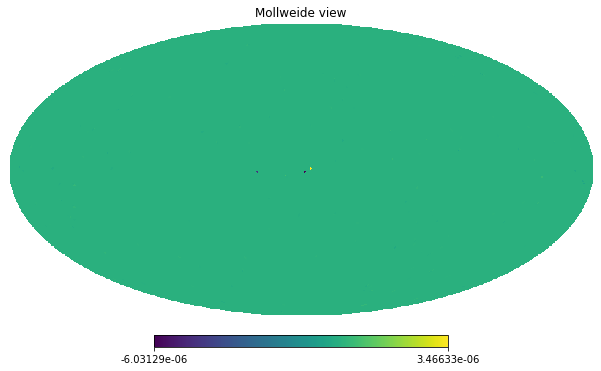

<Figure size 612x388.8 with 2 Axes>

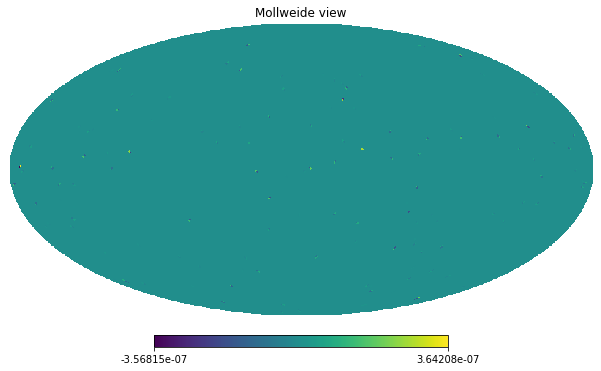

In [40]:
hp.mollview((m_noise_bin - m_noise_madam_bin)[0])
hp.mollview((m_noise_bin - m_noise_madam_bin)[1])

let's also plot the destriped maps

<Figure size 612x388.8 with 2 Axes>

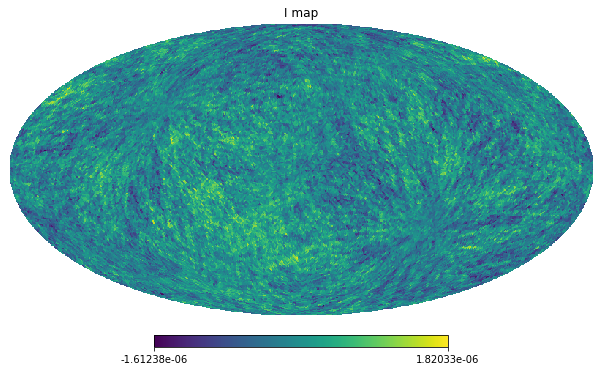

<Figure size 612x388.8 with 2 Axes>

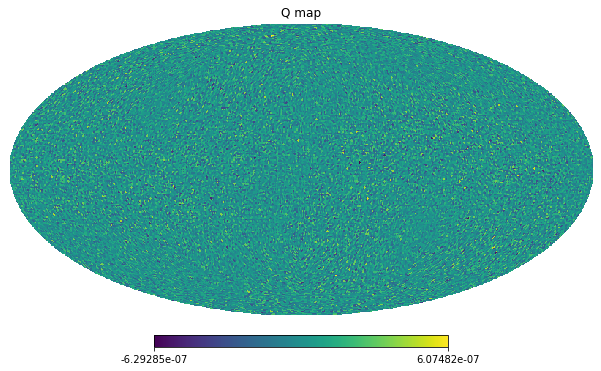

In [26]:
hp.mollview(m_noise_destr[0], title="I map")
hp.mollview(m_noise_destr[1], title="Q map")

computing the spectra

In [27]:
cl_map_original = hp.anafast(maps["M1-140"])
cl_map_noise_bin = hp.anafast(m_noise_bin)
cl_map_noise_madam_bin = hp.anafast(m_noise_madam_bin)
cl_map_noise_destr = hp.anafast(m_noise_destr)

Text(0.5, 0, '$\\ell$')

<Figure size 432x288 with 1 Axes>

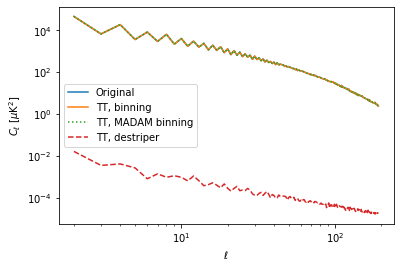

In [28]:
ell = np.arange(cl_map_noise_bin[0].size)
plt.loglog(ell[2:], cl_map_original[0, 2:] * 1e12, label="Original")
plt.loglog(ell[2:], cl_map_noise_bin[0, 2:] * 1e12, label="TT, binning")
plt.loglog(
    ell[2:], cl_map_noise_madam_bin[0, 2:] * 1e12, label="TT, MADAM binning", ls=":"
)
plt.loglog(ell[2:], cl_map_noise_destr[0, 2:] * 1e12, label="TT, destriper", ls="--")
plt.legend()
plt.ylabel(r"$C_{\ell}$ [$\mu$K$^2$]")
plt.xlabel(r"$\ell$")

Text(0.5, 0, '$\\ell$')

<Figure size 432x288 with 1 Axes>

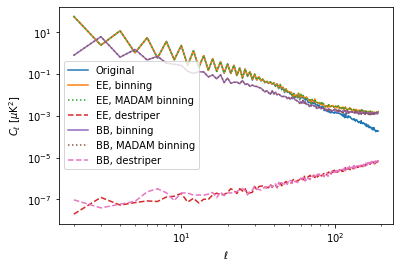

In [29]:
plt.loglog(ell[2:], cl_map_original[1, 2:] * 1e12, label="Original")
plt.loglog(ell[2:], cl_map_noise_bin[1, 2:] * 1e12, label="EE, binning")
plt.loglog(
    ell[2:], cl_map_noise_madam_bin[1, 2:] * 1e12, label="EE, MADAM binning", ls=":"
)
plt.loglog(ell[2:], cl_map_noise_destr[1, 2:] * 1e12, label="EE, destriper", ls="--")
plt.loglog(ell[2:], cl_map_noise_bin[2, 2:] * 1e12, label="BB, binning")
plt.loglog(
    ell[2:], cl_map_noise_madam_bin[2, 2:] * 1e12, label="BB, MADAM binning", ls=":"
)
plt.loglog(ell[2:], cl_map_noise_destr[2, 2:] * 1e12, label="BB, destriper", ls="--")
plt.legend()
plt.ylabel(r"$C_{\ell}$ [$\mu$K$^2$]")
plt.xlabel(r"$\ell$")

#### Making dipole TOD

In [30]:
(obs_dipole,) = sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # size,
)

If `sim.create_observations` is executed again, `sim.observations` is overwritten. In fact the TOD is null again:

In [31]:
for i_ob in range(len(sim.observations)):
    print(sim.observations[i_ob].tod)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [32]:
for obs in sim.observations:
    orbit = lbs.SpacecraftOrbit(obs.start_time)
    pos_vel = lbs.spacecraft_pos_and_vel(orbit=orbit, obs=obs, delta_time_s=86400.0)

In [33]:
for i_obs, obs in enumerate(sim.observations):
    lbs.add_dipole_to_observations(
        obs=obs,
        pos_and_vel=pos_vel,
        pointings=pointings[i_obs],
        dipole_type=lbs.DipoleType.TOTAL_FROM_LIN_T,
    )

[<matplotlib.lines.Line2D object at 0x7f2192130490>]

<Figure size 432x288 with 1 Axes>

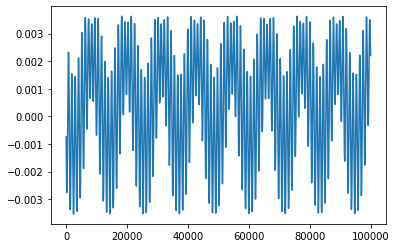

In [34]:
plt.plot(obs_dipole.tod[0, :100000])

In [35]:
for i_obs, obs in enumerate(sim.observations):
    m_dipole = lbs.make_bin_map(
        obs=obs,
        nside=nside,  # one can set also a different resolution than the input map
        pointings=pointings[i_obs],
        do_covariance=False,
        output_map_in_galactic=True,
    )

<Figure size 612x388.8 with 2 Axes>

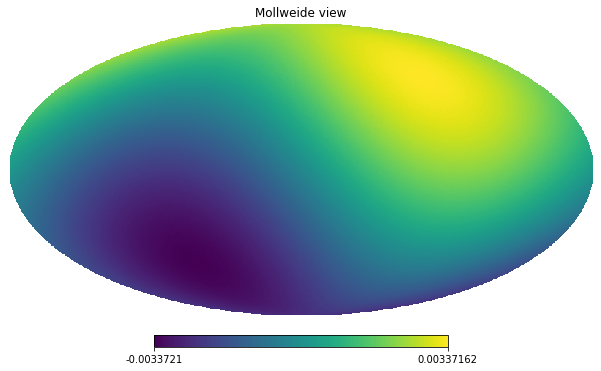

In [36]:
hp.mollview(m_dipole[0])

let's fit the dipole map to see if the dipole orientation agrees with Planck one (see arxiv:1807.06207)

colatitude: 0.7286226027948965,
longitude:  4.6080357444

In [37]:
hp.fit_dipole(m_dipole[0])

(-1.0213998958911062e-07, array([-0.00023297, -0.00222626,  0.00250823]))

In [38]:
hp.vec2ang(np.array([-0.00023297, -0.00222626, 0.00250823]))

(array([0.7286163]), array([4.60812212]))

the agreement is pretty good (we have also orbital dipole)